In [ ]:
# %pip install scikit-learn
# %pip install wget
# %pip uninstall transformers -y
# %pip install einops
# %pip install  torch torchvision
# %pip install torch torchvision --index-url https://download.pytorch.org/whl/cu124

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


import wget
import numpy as np
# import pandas as pd
import torch.nn as nn
# import torch.nn.functional as F


# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')


# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%config InlineBackend.figure_format = 'retina'



# try:
#     from einops import rearrange
# except ImportError:
#     %pip install einops
    # from einops import rearrange
from einops import rearrange


ModuleNotFoundError: No module named 'wget'

In [ ]:
# print(torch.cuda.is_available())
# print(torch.cuda.device_count())
# print(torch.cuda.current_device())
# print(torch.cuda.get_device_name(0))

# print(torch.cuda.is_available())

# print(device)

## PrePocessing

In [ ]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    wget.download("https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg", "dog.jpg")

In [ ]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
# img = torchvision.io.read_image("Lenna.png")
# img = torchvision.io.read_image("Main.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


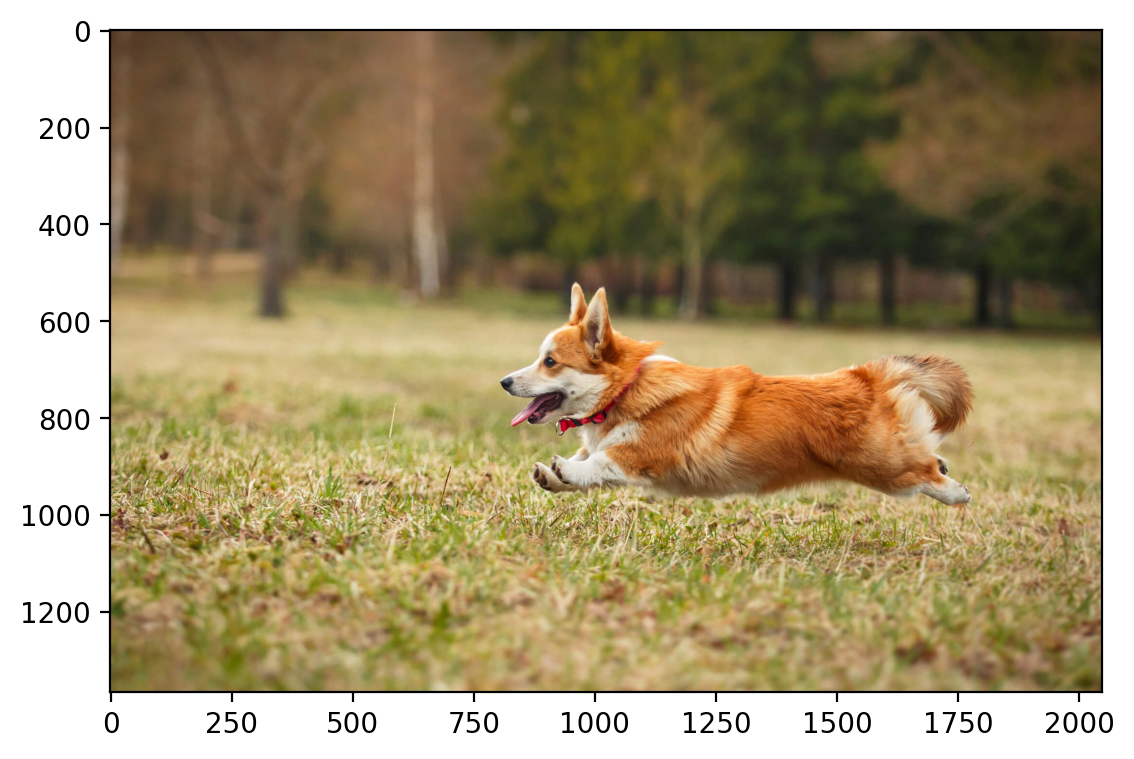

In [ ]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [ ]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [ ]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [ ]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [ ]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 230, 230)
# crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 0, 0, 220, 220)
crop.shape

torch.Size([3, 230, 230])

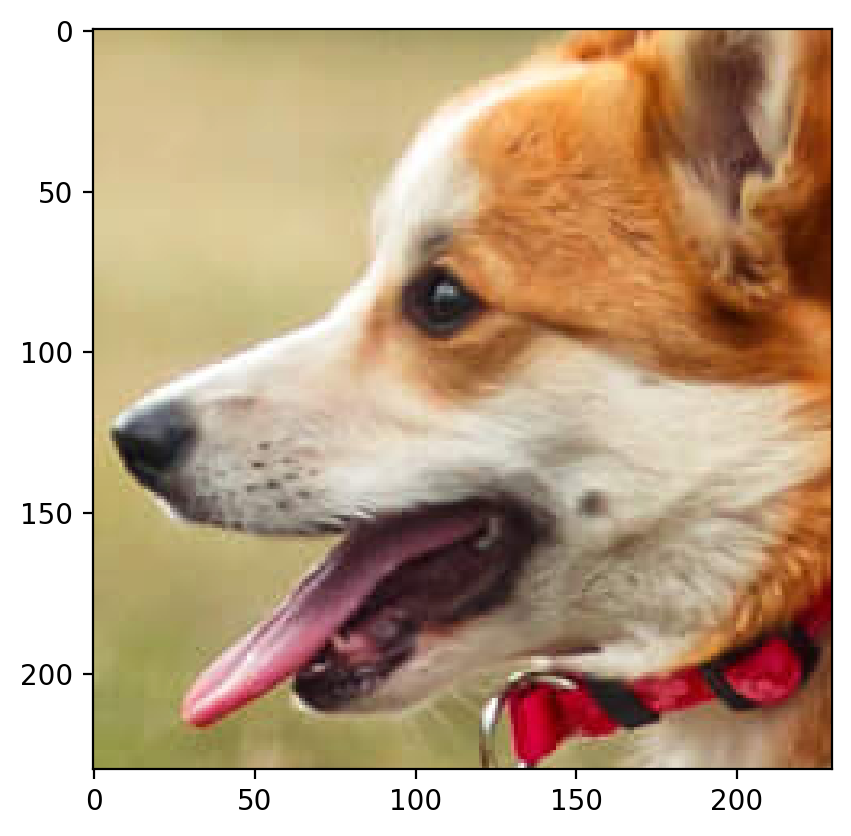

In [ ]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())


In [ ]:
crop = crop.to(device)


In [ ]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 230 230


In [ ]:
num_channels, height, width = 2, 3, 4


# Create a 2D grid of (x,y) coordinates
w_coords = torch.arange(width).repeat(height, 1)
h_coords = torch.arange(height).repeat(width, 1).t()
w_coords = w_coords.reshape(-1)
h_coords = h_coords.reshape(-1)

# Combine the x and y coordinates into a single tensor
X = torch.stack([h_coords, w_coords], dim=1).float()

In [ ]:
X.shape

torch.Size([12, 2])

In [ ]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width, dtype=torch.float16).repeat(height, 1)
    h_coords = torch.arange(height, dtype=torch.float16).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').to(torch.float32)
    return X, Y

In [ ]:
dog_X, dog_Y = create_coordinate_map(crop)

dog_X.shape, dog_Y.shape

(torch.Size([52900, 2]), torch.Size([52900, 3]))

In [ ]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [ ]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [ ]:
# # create RFF features
# def create_rff_features(X, num_features, sigma):
#     from sklearn.kernel_approximation import RBFSampler
#     rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
#     X = X.cpu().numpy()
#     X = rff.fit_transform(X)
#     return torch.tensor(X, dtype=torch.float32).to(device)

In [ ]:
def create_rff_features(X, num_features, sigma, batch_size=2000):
    """
    Transform the input data X using RBFSampler in batches and move the result to GPU.

    Args:
    - X (torch.Tensor): Input data of shape (num_samples, num_features)
    - num_features (int): Number of features for RBFSampler
    - sigma (float): Parameter for the RBF kernel
    - batch_size (int): Size of the batch for processing

    Returns:
    - torch.Tensor: Transformed data on GPU
    """
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))

    X = X.cpu().numpy().astype(np.float16)  # Use float32 to reduce memory usage

    num_batches = (X.shape[0] + batch_size - 1) // batch_size
    all_transformed_batches = []

    for i in range(num_batches):
        # Calculate batch indices
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, X.shape[0])
        batch_X = X[start_idx:end_idx]

        # Fit the RBFSampler on the first batch
        if i == 0:
            rff.fit(batch_X)

        # Transform the current batch
        transformed_batch = rff.transform(batch_X)

        # Convert the transformed batch to PyTorch tensor and move to GPU
        transformed_tensor = torch.tensor(transformed_batch, dtype=torch.float32).to(device)

        # Append to list of batches
        all_transformed_batches.append(transformed_tensor)

    # Concatenate all transformed batches on GPU
    X_transformed = torch.cat(all_transformed_batches, dim=0)

    return X_transformed

In [ ]:
X_rff = create_rff_features(dog_X_scaled, 36000, 0.009)
# X_rff = create_rff_features(dog_X_scaled, 4000, 0.009)


In [ ]:
# torch.cuda.empty_cache()


In [ ]:
print(X_rff.shape)

# X_rff.dtype
print(dog_Y.dtype)

torch.Size([52900, 36000])
torch.float32


In [ ]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.004, X_rff, dog_Y, 2500)


Epoch 0 loss: 0.374511
Epoch 100 loss: 0.074705
Epoch 200 loss: 0.018949
Epoch 300 loss: 0.009020
Epoch 400 loss: 0.005611
Epoch 500 loss: 0.003663
Epoch 600 loss: 0.002405
Epoch 700 loss: 0.001572
Epoch 800 loss: 0.001022
Epoch 900 loss: 0.000665
Epoch 1000 loss: 0.000440
Epoch 1100 loss: 0.000303
Epoch 1200 loss: 0.000221
Epoch 1300 loss: 0.000175
Epoch 1400 loss: 0.000149
Epoch 1500 loss: 0.000134
Epoch 1600 loss: 0.000126
Epoch 1700 loss: 0.000122
Epoch 1800 loss: 0.000119
Epoch 1900 loss: 0.000118
Epoch 2000 loss: 0.000116
Epoch 2100 loss: 0.000115
Epoch 2200 loss: 0.000115
Epoch 2300 loss: 0.000114
Epoch 2400 loss: 0.000113


0.0001129135926021263

In [ ]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
# import torch
# import numpy as np

# def plot_reconstructed_and_original_image(original_img, net, X, title=""):
#     """
#     net: torch.nn.Module
#     X: torch.Tensor of shape (num_samples, 2)
#     Y: torch.Tensor of shape (num_samples, 3)
#     """
#     num_channels, height, width = original_img.shape
#     net.eval()
#     with torch.no_grad():
#         outputs = net(X)
#         outputs = outputs.reshape(height, width, num_channels)

#     # Move outputs and original_img to CPU for plotting and saving
#     outputs_cpu = outputs.cpu().numpy()  # Convert to NumPy array
#     original_img_cpu = original_img.cpu().numpy()  # Convert to NumPy array

#     # Plot the reconstructed and original images
#     fig = plt.figure(figsize=(6, 4))
#     gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

#     ax0 = plt.subplot(gs[0])
#     ax1 = plt.subplot(gs[1])

#     # Display the images
#     ax0.imshow(outputs_cpu)
#     ax0.set_title("Reconstructed Image")

#     ax1.imshow(np.transpose(original_img_cpu, (1, 2, 0)))  # Convert from (C, H, W) to (H, W, C) for display
#     ax1.set_title("Original Image")

#     for a in [ax0, ax1]:
#         a.axis("off")

#     # Save the images after moving them to the CPU and converting to NumPy
#     save_image_with_matplotlib(outputs_cpu, "reconstructed_image.png")
#     save_image_with_matplotlib(np.transpose(original_img_cpu, (1, 2, 0)), "original_image.png")

#     # Add title and layout
#     fig.suptitle(title, y=0.9)
#     plt.tight_layout()



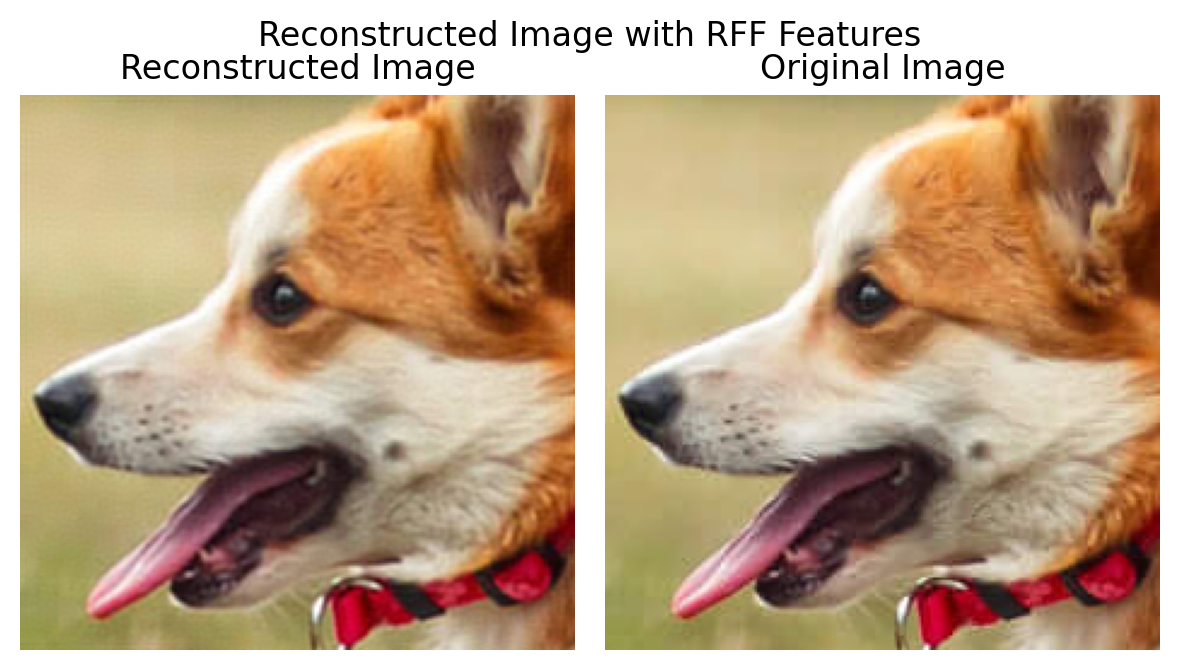

In [ ]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

In [1]:
import matplotlib.pyplot as plt

def save_image_with_matplotlib(image_array, filename):
    """
    Save a NumPy array as an image using matplotlib's imsave function.
    Assumes the image array is in (H, W, 3) format for RGB images.
    """
    plt.imsave(filename, np.clip(image_array, 0, 1))  # Clip to [0, 1] range for float arrays

# Example usage
# Assuming original_image and reconstructed_image are NumPy arrays



In [3]:
img = torchvision.io.read_image("original_image.png")


In [4]:
imshow(img)

NameError: name 'imshow' is not defined